In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with NISQ-HHL

In this tutorial, we present the details of NISQ-HHL, a Qiskit implementation of a hybrid HHL algorithm so called because of its suitability for near-term quantum hardware. Our exploration is based on Yalovetzky et al. 2021.<sup>1</sup>


In general, the HHL algorithm solves linear system problems:
$$A \vec{x} = \vec{b},$$

where $A\in\mathbb{C}^{n \times n}$ is a matrix, $\vec{b}\in\mathbb{C}^{n}$ is a vector, and $\vec{x}\in\mathbb{C}^{n}$ is our solution vector. Solving this equation prepares the quantum state 

$$|x\rangle = A^{-1} |\vec{b}\rangle.$$ 

The original HHL algorithm requires a significant amount of qubits and extremely long coherent computation. In particular, the inversion of eigenvalues, which is a crucial component of the HHL algorithm, requires a long coherent computation of the arcsine function using quantum arithmetic.

A hybrid HHL algorithm suggested by Lee et al. 2019<sup>2</sup> reduced the computational cost associated with the eigenvalue inversion component by construction based on prior information about the eigenvalues of a target matrix. Yalovetzky et al. further enhanced the previous work by introducing a novel method for choosing the optimal evolution time for the Hamiltonian simulation and quantum conditional logic quantum phase estimation (QCL-QPE) by utilizing mid-circuit measurement and qubit reset and reuse.


#### Import packages

In [2]:
import numpy as np
from math import isclose
from scipy.sparse import diags
from scipy.linalg import expm

from qiskit_aer import Aer
from qiskit import ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PhaseEstimation, UCRYGate, Isometry
from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings('ignore')

### Matrix and vector

The HHL algorithm is a quantum algorithm used to solve systems of linear equations 
$$A \vec{x} = \vec{b},$$
where the matrix $A$ is Hermitian, $s$-sparse, and has a low condition number $\kappa$.
Additionally, we assume that efficient oracles exist for loading the data.
  
In this tutorial, we also assume that the matrix $A$ is positive-definite, 
but this restriction can be easily removed. 

As an example, we use a tridiagonal Toeplitz matrix, where a $4 \times 4$ tridiagonal Toeplitz matrix has the form:
$$
A(p, q) = 
\begin{bmatrix}
p & q & 0 & 0 \\
q & p & q & 0 \\
0 & q & p & q \\
0 & 0 & q & p
\end{bmatrix}.
$$

Here we define our vector $\vec{b} = [1, 0, 0, 0]^T$ and our matrix $A$ as follows:

In [3]:
def tridiagonal_toeplitz(rank: int, main_diag: float, off_diag: float):
    matrix = diags(
            [off_diag, main_diag, off_diag],
            [-1, 0, 1],
            shape=(rank, rank)
        ).toarray()
    return matrix


num_data_qubits = 2

r = 2 ** num_data_qubits
p = 1 / 4
q = - 1 / 8

tri_matrix = tridiagonal_toeplitz(r, p, q)
print("Matrix elements")
print(tri_matrix)

Matrix elements
[[ 0.25  -0.125  0.     0.   ]
 [-0.125  0.25  -0.125  0.   ]
 [ 0.    -0.125  0.25  -0.125]
 [ 0.     0.    -0.125  0.25 ]]


The minimum and maximum eigenvalues of $A$ and the condition number $\kappa$ is the following, which will be used when checking the validity of our hybrid HHL algorithm implementation.

In [4]:
eigvals = np.linalg.eigvalsh(tri_matrix)
eig_min = eigvals[0]
eig_max = eigvals[-1]
cond = np.linalg.cond(tri_matrix)
print("Eigenvalue bounds: {}, {}".format(eig_min, eig_max))
print("Condition number: {}".format(cond))


Eigenvalue bounds: 0.04774575140626312, 0.4522542485937369
Condition number: 9.472135954999578


### Unitary time evolution operator

We define the time evolution operator of $A$ as
$$U(A, \gamma) = e^{- 2 \pi i A \gamma},$$
where $\gamma$ is a scaling parameter of $A$.

Here we calculate $U(A, \gamma)$ by the method `unitary_evolution` and decompose the operator into the basis gate set by the built-in Qiskit function `transpile`.

In [5]:
def unitary_evolution(matrix, gamma):
    evolution_time = 2 * np.pi * gamma
    num_state_qubits = int(np.log2(matrix.shape[0]))
    qc = QuantumCircuit(num_state_qubits)
    evolved = expm(1j * matrix * evolution_time)
    qc.unitary(evolved, qc.qubits)
    return qc


### Phase estimation by QCL-QPE

As in iterative quantum phase estimation (IQPE), quantum condidtional logic QPE (QCL-QPE) needs only one ancilla qubit, as shown in the figure below.
While IQPE assumes the preparation of an eigenstate of $A$, QCL-QPE works with a reference state that is a superposition of the eigenstates of $A$.

![fig](fig/qcl-qpe.png)

`Construct_qcl_circuit` returns a quantum circuit for running QCL-QPE, and `qcl_estimate` returns a phase estimation result.

In [6]:
def construct_qcl_circuit(unitary, ref_state, nl):
    # auxiliary qubit
    qa = QuantumRegister(1, name="a")
    # classical bits to store phase
    creg_list = [ClassicalRegister(1, name="c{}".format(i)) for i in range(nl)]
    # qubits to encode |b>
    qb = QuantumRegister(unitary.num_qubits, name="b")

    qc = QuantumCircuit(qb, qa)
    for c in creg_list:
        qc.add_register(c)

    qc.append(ref_state, qb)

    for k in range(nl, 0, -1):
        qc.reset(qa)
        qc.h(qa)
        # controlled-U
        unitary_power = unitary.power(2 ** (k - 1)).control()
        qc = qc.compose(unitary_power, qa[:] + qb[:])
        for i in range(nl - k):
            p = nl - k - i
            qc.p(- np.pi / 2 ** p, qa).c_if(creg_list[i], 1)
        qc.h(qa)
        qc.measure(qa, creg_list[nl - k])

    return qc


def qcl_estimate(unitary, ref_state, num_reg_qubits, backend, shots=1024):
    qc = construct_qcl_circuit(unitary, ref_state, num_reg_qubits)
    job = backend.run(transpile(qc, backend), shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return {k.replace(" ", ""): counts[k] / shots for k in counts.keys()}

We perform a Hamiltonian simulation of $A$ and QCL-QPE under the following conditions:
* Estimate the phases in 5-bit precision ($\ell = 5$)
* Use reference state $| b \rangle = | 00 \rangle$

The quantum circuits for QCL-QPE are shown below:

In [7]:
unitary = unitary_evolution(tri_matrix, 1.0)
ref_state = QuantumCircuit(num_data_qubits)
num_reg_qubits = 5

qc = construct_qcl_circuit(unitary, ref_state, num_reg_qubits)
qc.draw("mpl")

### Scaling factor optimization algorithm

The algorithms that optimize the scaling factor $\gamma$ described in Yalovetzky et al. 2021<sup>1</sup> are implemented using the following parameters:

* “Algorithm 1” → `optimize_scaling_parameter`
* “Algorithm 2” → `is_valid_scaling_parameter`

The descriptions of each method are as follows:

##### `is_valid_scaling_parameter`

Given an input value $\alpha$ and a matrix $A$, `is_valid_scaling_parameter` determines whether $\alpha$ is larger than the largest eigenvalue of $A$, $\lambda_{\mathrm{max}}$ ($||A / \alpha||$ < 1).

Defining $\Gamma^{-1} = 2^{n+1} \alpha$ by running the phase estimation
$$e^{2 \pi i A \Gamma} | b \rangle | 0^{\ell} \rangle \to \sum_k e^{2 \pi i \lambda_k \Gamma} \beta_k | u_k \rangle | \lambda_k \rangle,$$

it estimates the eigenvalues in $\ell$-bit precision. 
Then, by comparing the largest eigenvalue and 0 in $\ell$-bit precision, it decides if $\lambda_{\mathrm{max}} / \alpha < 1$.

##### `largest_phase`

Given the dictionary data `{key: value}`, where
* `key`: bit-string expressing phase
* `value`: frequency with which the bit strings are measured,

and `threshold`, it returns the largest phase whose frequency is larger than the threshold value.

##### `optimize_scaling_parameter`

Given an input value $\alpha$ that satisfies ($||A / \alpha||$ < 1), it outputs the optimized scaling factor $\gamma$, such that $\lambda_{\mathrm{max}} \gamma \approx 1$.

In [8]:
def is_valid_scaling_parameter(matrix, alpha, num_reg_qubits, ref_state, backend, threshold=0.1, shots=1024):
    gamma = (2 ** (num_reg_qubits + 1)) * alpha
    gamma = 1 / gamma
    unitary = unitary_evolution(matrix, gamma)

    phases = qcl_estimate(unitary, ref_state, num_reg_qubits, backend, shots=shots)
    p0 = phases["0" * num_reg_qubits]
    return (p0 > 1 - threshold)


def largest_phase(phases, threshold):
    bitstrings = list(phases.keys())
    bitstrings.sort(reverse=True)
    
    max_bitstring = None
    for s in bitstrings:
        if phases[s] > threshold:
            max_bitstring = s
            break

    return max_bitstring


def optimize_scaling_parameter(matrix, alpha, num_reg_qubits, ref_state, backend, cutoff=0.01, shots=1024):
    MAX_PHASE = 2 ** num_reg_qubits - 1
    gamma = 1 / alpha
    x = 0
    while (x < MAX_PHASE):
        unitary = unitary_evolution(matrix, gamma)
        phases = qcl_estimate(unitary, ref_state, num_reg_qubits, backend, shots=shots)
        max_bitstring = largest_phase(phases, cutoff)
        x = int(max_bitstring, 2)
        if max_bitstring == ("0" * num_reg_qubits):
            gamma = gamma * (MAX_PHASE + 1)
        else:
            gamma = gamma * MAX_PHASE / x
    
    return gamma

In this tutorial, we use `AerSimulator` for our backend.

We choose $\alpha = 1$ as a large enough value and validate this assumption by running `is_valid_scaling_parameter`.

Then, by running `optimize_scaling_parameter`, we obtain the optimal scaling parameter.

In [9]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024

In [10]:
alpha = 1
is_vaild = is_valid_scaling_parameter(tri_matrix, alpha, num_reg_qubits, ref_state, backend, shots=shots)
print("Is alpha large enough?: {}".format(is_vaild))

cutoff = 0.01
opt_gamma = optimize_scaling_parameter(tri_matrix, alpha, num_reg_qubits, ref_state, backend, cutoff=cutoff, shots=shots)
print("Optimal gamma: {}".format(opt_gamma))

Is alpha large enough?: True
Optimal gamma: 2.135555555555556


We see that $\alpha = 1$ indeed is a large enough value for $||A||$.

We can also see that the optimal scaling factor $\gamma_{\mathrm{opt}}$ is close to the inverse of the largest eigenvalue of $A$, that is,
$$\gamma_{\mathrm{opt}} \lambda_{\mathrm{max}} = 0.45 \times 2.14 = 0.96 \approx 1.$$

Given $\gamma_{\mathrm{opt}}$, we run QPE and obtain some of the eigenvalues of $A$ and a distribution of finding them.

In [11]:
unitary = unitary_evolution(tri_matrix, opt_gamma)

phases = qcl_estimate(unitary, ref_state, num_reg_qubits, backend, shots=shots)
print("Phases: {}".format(phases))

Phases: {'00110': 0.0009765625, '01111': 0.0009765625, '10010': 0.0009765625, '11011': 0.001953125, '11110': 0.0009765625, '01011': 0.013671875, '00001': 0.001953125, '11010': 0.00390625, '00010': 0.0029296875, '00000': 0.0029296875, '10101': 0.0244140625, '00101': 0.005859375, '11001': 0.00390625, '00111': 0.0009765625, '10100': 0.0068359375, '01110': 0.00390625, '10011': 0.005859375, '10111': 0.0654296875, '01101': 0.0087890625, '01100': 0.3134765625, '00100': 0.009765625, '01010': 0.00390625, '10001': 0.005859375, '01000': 0.001953125, '11000': 0.0166015625, '10110': 0.2216796875, '11111': 0.1416015625, '00011': 0.125, '01001': 0.0029296875}


The histogram below shows the probability distribution of finding the phases estimated by QPE.

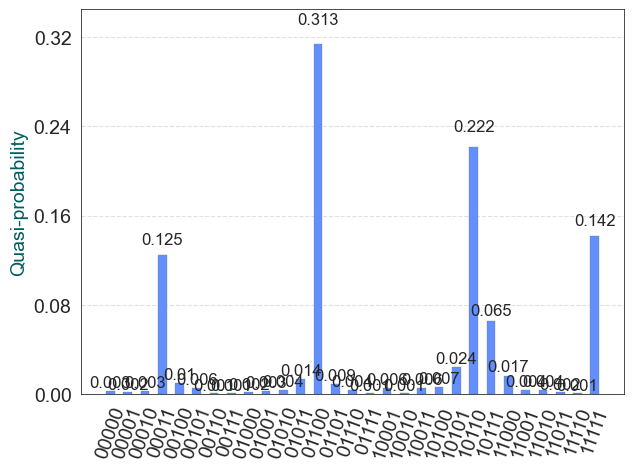

In [12]:
plot_histogram(phases)

### Eigenvalue filtering

Given a set of eigenvalues of matrix $A$ and the probability distribution of measuring them, the `filtered_phases` function sorts the eigenvalues in descending order according to the probability of measurement. Moreover, it filters the phases by using the `max_count` argument and returns the first $m$ eigenvalues, where $m$ is specified by `max_count`.

In [13]:
def filtered_phases(phases, max_count):
    sorted_phases = list(sorted(phases.items(), key=lambda item: item[1], reverse=True))
    filtered_phases = [k for k, v in sorted_phases[0:max_count]]
    return filtered_phases

In [14]:
cutoff = 0.01
max_count = 5
m_phases = filtered_phases(phases, max_count)
print("Filtered phases: {}".format(m_phases))

Filtered phases: ['01100', '10110', '11111', '00011', '10111']


Here, each of the filtered phases corresponds to the scaled eigenvalues ($\gamma \lambda_i$).

The smallest phases $\gamma \lambda_{\mathrm{min}}$ among the filtered ones are used as the normalization constant when finding the rotation angles of the controlled rotation gates in the next step.

In [15]:
m_eigvals = [int(p, 2) / (2 ** num_reg_qubits) for p in m_phases]
print("Filtered eigenvalues: {}".format(m_eigvals))

Filtered eigenvalues: [0.375, 0.6875, 0.96875, 0.09375, 0.71875]


### Ancilla quantum encoding (AQE)

We now encode the inverse of the selected eigenvalues in an ancilla qubit as follows:
$$\sum_k \beta_k | u_k \rangle | \lambda_k \rangle | 0 \rangle \to \sum_k \beta_k | u_k \rangle | \lambda_k \rangle \left( \sqrt{1 - \frac{C^2}{\lambda^2_k}}| 0 \rangle + \frac{C}{\lambda_k} | 1 \rangle \right),$$
where $C$ is a constant that satisfies $|C| \leq \lambda_{\mathrm{min}}$.
Here, we choose $C = \lambda_{\mathrm{min}}$.

As shown in the figure below, we use the uniformly controlled Ry (UCRY) gate, also called the multiplexed Ry gate, to encode the inverse of eigenvalues $\lambda_k = k / 2^{\ell}$ for $0 \leq k < 2^{\ell}$ by choosing $\theta_k = 2 \arcsin(C / \lambda_k)$, where each $\theta_k$ is the rotation angle of $U_k$.

![title](fig/multiplexed_u_gates.png)

Note that here we calculate only $m$ $\theta_k$, where $m$ is specified by `max_count`.
Each $\theta_k$ is calculated using `rot_angles`.

In [16]:
def rot_angles(nl, eigs, scaling):
    eigs_dec = [int(s[::-1], 2) for s in eigs]
    
    angles = [0.0]
    for i in range(1, 2 ** nl):
        if i in eigs_dec:
            bitstr = eigs[eigs_dec.index(i)]
            angle = scaling * 2 ** nl / int(bitstr, 2)
            if isclose(angle, 1, abs_tol=1e-5):
                angles.append(np.pi)
            elif angle < 1:
                angles.append(2 * np.arcsin(angle))
            else:
                angles.append(0.0)
        else:
            angles.append(0.0)
    
    return angles

### NISQ-HHL quantum circuit

With $\ell$-register qubits and the built-in Qiskit module `PhaseEstimation`, the hybrid HHL algorithm is implemented as below:

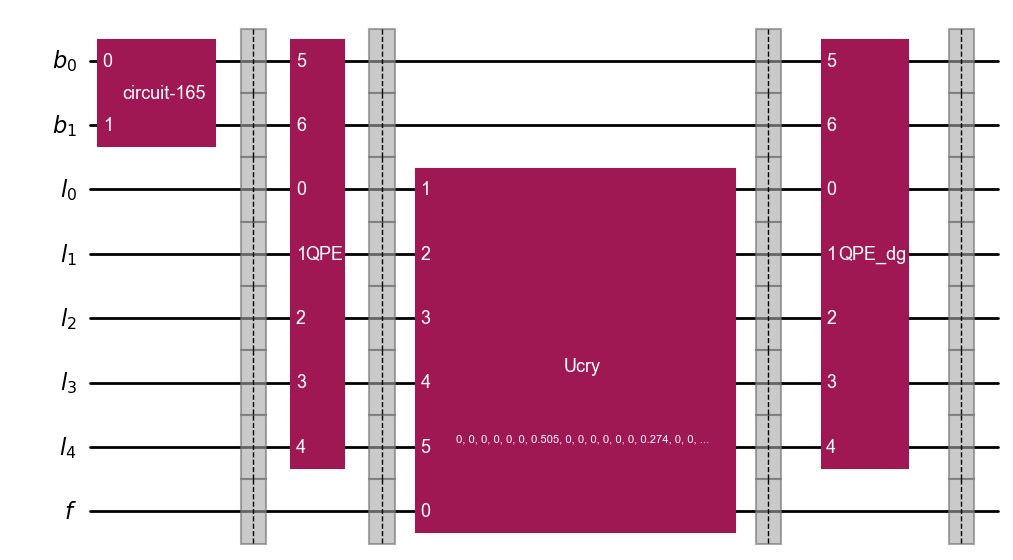

In [17]:
# Initialize quantum registers
# Number of qubits representing |b>
qb = QuantumRegister(size=num_data_qubits, name="b")

# Number of qubits representing eigenvalues
ql = QuantumRegister(size=num_reg_qubits, name="l")

matrix_circuit = unitary_evolution(tri_matrix, opt_gamma)

# Number of flag qubits due to probabilistic state preparation
qf = QuantumRegister(size=1, name="f")

# Initialize the quantum circuit
hhl_qc = QuantumCircuit(qb, ql, qf)
        
# State preparation
hhl_qc.append(ref_state, qb[:])
hhl_qc.barrier()

# QPE
phase_estimation = PhaseEstimation(num_reg_qubits, matrix_circuit)
hhl_qc.append(phase_estimation, ql[:] + qb[:])

hhl_qc.barrier()

# AQE
scaling = min(m_eigvals)
angles = rot_angles(num_reg_qubits, m_phases, scaling)
ucry = UCRYGate(angles)
hhl_qc.append(ucry, qf[:] + ql[:])

hhl_qc.barrier()

# QPE inverse
hhl_qc.append(phase_estimation.inverse(), ql[:] + qb[:])

hhl_qc.barrier()

hhl_qc.draw(output="mpl")

### Comparison with classical solver

We evaluate the accuracy of the solution generated by hybrid HHL by comparing the output state with the result vector calculated by a classical solver. 
More specifically, we measure the distance between the output state of hybrid HHL and one of the classical solver by running the SWAP test.

We now encode the output vector $\vec{x} = A^{-1} \vec{b}$ by using `NumPyLinearSolver` as the `test_state`:

In [18]:
vector = np.array([1] + [0] * (2 ** num_data_qubits - 1))
x_classical_state = np.linalg.solve(tri_matrix, vector / np.linalg.norm(vector))
x_classical_euclidean_norm = np.linalg.norm(x_classical_state)
print(x_classical_state / x_classical_euclidean_norm)

test_state = QuantumCircuit(num_data_qubits)
isometry = Isometry(x_classical_state / x_classical_euclidean_norm, 0, 0)
test_state.append(isometry, list(range(num_data_qubits)))

[0.73029674 0.54772256 0.36514837 0.18257419]


Then, we implement a quantum circuit for running the SWAP test.

In [19]:
# Outer circuit
# Initialize the quantum registers
qa = QuantumRegister(size=1, name="a")
ca = ClassicalRegister(size=1, name="ca")

# Qubits representing |b> and solution |x>
qx = QuantumRegister(size=num_data_qubits, name="x")
qh = QuantumRegister(size=hhl_qc.num_qubits, name="h")

# Classical bit for flag
cf = ClassicalRegister(size=1, name="cf")

# Initialize the quantum circuit
qc = QuantumCircuit(qa, qx, qh, cf, ca)
        
# State preparation for |x> and |b>
qc.append(test_state, qx[:])
qc.append(hhl_qc, qh[:])
qc.measure(qh[-1], cf)
qc.barrier()

# SWAP test
qc.h(qa)
for i in range(num_data_qubits):
    qc.cswap(qa, qx[i], qh[i])
qc.h(qa)

qc.measure(qa, ca)

qc.draw(output="mpl")

Note that there are two classical bits named **`cf`** and **`ca`**, which encode the measurement results:
- **`cf`** encodes the flag bit associated with the success or failure of the hybrid HHL algorithm
- **`ca`** encodes the inner product of the two states associated with the SWAP test

The probability of finding **`ca`** is 0 and the value of the inner product of $| x \rangle$ and $| A^{-1} b \rangle$ has the following relation:

$$p(c_a = 0) = \frac{1 + |\langle x | A^{-1} b \rangle|^2}{2}$$

We obtain the following outcome of the SWAP test:

In [20]:
job = backend.run(transpile(qc, backend), shots=1024)
result = job.result()
counts = result.get_counts(qc)
print(counts)

{'0 1': 130, '1 1': 3, '0 0': 538, '1 0': 353}


Here, since the keys `"0 0"`, `"1 0"` indicate the failure of the hybrid HHL algorithm, we discard that data.

$p(c_a = 0)$ and the fidelity can be calculated as follows:

In [21]:
p0 = counts["0 1"] / (counts["0 1"] + counts["1 1"])
print("Fidelity: {}".format(2 * p0 - 1))

Fidelity: 0.9548872180451127


### Reference

1. <a id='Yalovetzky et al.'></a>Romina Yalovetzky et al. “NISQ-HHL: Portfolio Optimization for Near-Term Quantum Hardware.” arXiv:2110.15958, 2021. https://arxiv.org/pdf/2110.15958.pdf.

2. <a id='Y. Lee et al.'></a>Yonghae Lee et al. “Hybrid quantum linear equation algorithm and its experimental test on IBM Quantum Experience”, *Scientific Reports*, vol. 9, no. 4778 (2019): 1–12. https://www.nature.com/articles/s41598-019-41324-9.

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>